🖼️  Running Inference on Normal Images...
Running inference on: image (1).jpg

image 1/1 /kaggle/input/image-data/image (1).jpg: 448x640 (no detections), 69.1ms
Speed: 8.9ms preprocess, 69.1ms inference, 67.5ms postprocess per image at shape (1, 3, 448, 640)


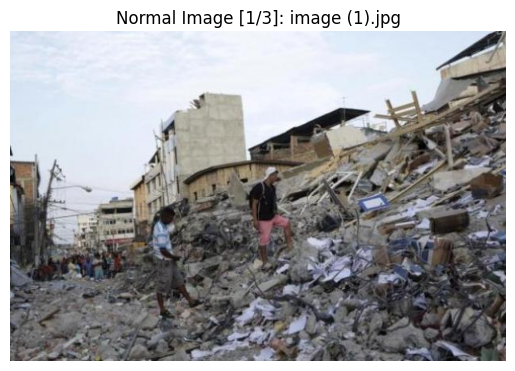

-------------------------
Running inference on: image.jpg

image 1/1 /kaggle/input/image-data/image.jpg: 416x640 1 humans, 62.3ms
Speed: 1.7ms preprocess, 62.3ms inference, 191.5ms postprocess per image at shape (1, 3, 416, 640)


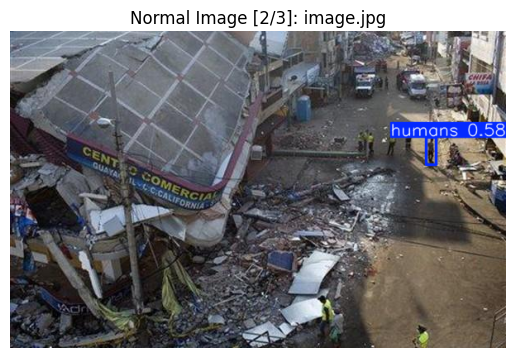

-------------------------
Running inference on: Screenshot (379).png

image 1/1 /kaggle/input/image-data/Screenshot (379).png: 384x640 1 humans, 44.0ms
Speed: 1.9ms preprocess, 44.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


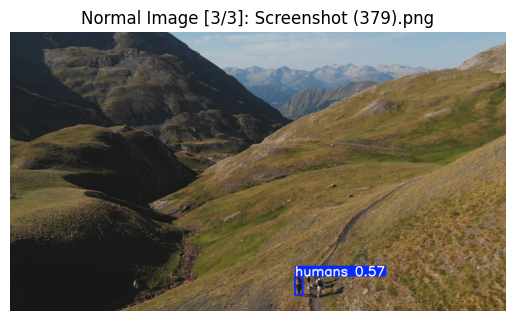

-------------------------

🔥 Running Inference on Thermal Images...
Running inference on: thermal2.jpg

image 1/1 /kaggle/input/image-data/thermal2.jpg: 480x640 1 person, 76.6ms
Speed: 1.6ms preprocess, 76.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


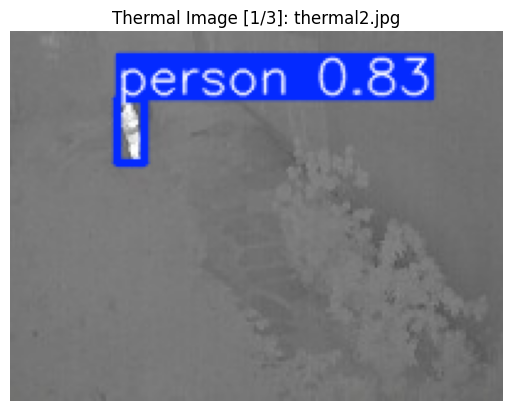

-------------------------
⚠️ Error: Image file not found at /kaggle/input/image-data/thermal3.jpg
-------------------------
Running inference on: FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg

image 1/1 /kaggle/input/image-data/FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg: 640x640 6 persons, 58.2ms
Speed: 1.5ms preprocess, 58.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


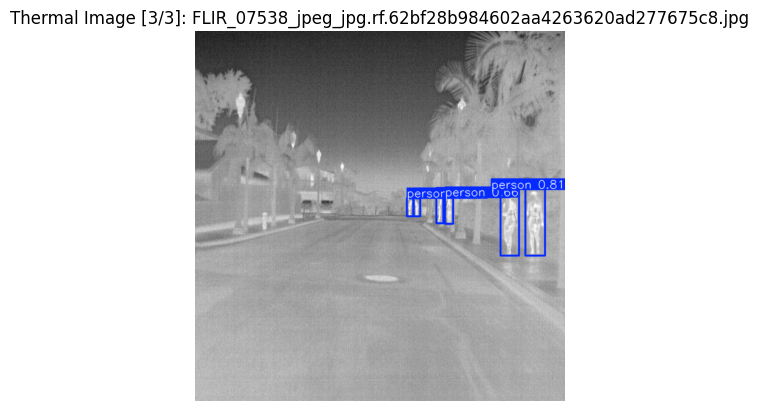

-------------------------

🔊 Running Inference on Audio File...
Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s] 


🔊 Audio Inference Result: Human Detected


In [1]:
import os
import cv2
import torch
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from ultralytics import YOLO

# ─── PATHS ────────────────────────────────────────────────
# These paths are set up for the Kaggle environment
ROOT = "/kaggle/input"
MODEL_PATHS = {
    "image": os.path.join(ROOT, "dl-models/other/default/1/image.pt"),
    "thermal": os.path.join(ROOT, "dl-models/other/default/1/thermal.pt"),
    "audio": os.path.join(ROOT, "dl-models/other/default/1/screaming_detector_gpu.pth"),
}

# 🔽 ACTION REQUIRED: Update the filenames below with your actual image files 🔽
INPUT_PATHS = {
    "image": [
        os.path.join(ROOT, "image-data/image (1).jpg"), # <-- CHANGE FILENAME
        os.path.join(ROOT, "image-data/image.jpg"), # <-- CHANGE FILENAME
        os.path.join(ROOT, "image-data/Screenshot (379).png"), # <-- CHANGE FILENAME
    ],
    "thermal": [
        os.path.join(ROOT, "/kaggle/input/image-data/thermal2.jpg"), # <-- CHANGE FILENAME
        os.path.join(ROOT, "/kaggle/input/image-data/thermal3.jpg"), # <-- CHANGE FILENAME
        os.path.join(ROOT, "/kaggle/input/image-data/FLIR_07538_jpeg_jpg.rf.62bf28b984602aa4263620ad277675c8.jpg"), # <-- CHANGE FILENAME
        # os.path.join(ROOT, "image-dataset/thermal-image-4.png"), # <-- CHANGE FILENAME
    ],
    "audio": os.path.join(ROOT, "audio-dataset/PES University Road 5.m4a"),
}

# ─── AUDIO MODEL ───────────────────────────────────────────
class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.backbone.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        in_f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_f, 2)

    def forward(self, x):
        return self.backbone(x)

# Helper to rename keys in state_dict
def convert_state_dict_keys(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("resnet."):
            new_key = k.replace("resnet.", "backbone.")
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

# ─── IMAGE DISPLAY FUNCTION ───────────────────────────────
def show_img(img, title=""):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ─── INFERENCE FUNCTIONS ──────────────────────────────────
def run_yolo_inference(model_path, image_path, label="YOLO Output"):
    """Runs YOLO inference and displays the result."""
    if not os.path.exists(image_path):
        print(f"⚠️ Error: Image file not found at {image_path}")
        return
    print(f"Running inference on: {os.path.basename(image_path)}")
    model = YOLO(model_path)
    results = model(image_path)
    img = results[0].plot()
    show_img(img, title=label)

def run_audio_inference(model_path, audio_path):
    """Runs audio classification inference and prints the result."""
    if not os.path.exists(audio_path):
        print(f"⚠️ Error: Audio file not found at {audio_path}")
        return
        
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    model = AudioClassifier()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(convert_state_dict_keys(state_dict))
    model.to(device)
    model.eval()

    wave, sr = torchaudio.load(audio_path)
    wave = wave.to(device)
    
    target_sr, dur = 22050, 22050 * 3
    if sr != target_sr:
        wave = torchaudio.transforms.Resample(sr, target_sr).to(device)(wave)
    if wave.ndim > 1: wave = wave.mean(dim=0, keepdim=True)
    if wave.shape[-1] < dur: wave = torch.nn.functional.pad(wave, (0, dur - wave.shape[-1]))
    else: wave = wave[..., :dur]

    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr, n_mels=64).to(device)
    mel = mel_transform(wave)
    spec = torch.log(mel + 1e-9).unsqueeze(0)

    with torch.no_grad():
        output = model(spec)
    
    pred = "Human Detected" if int(output.argmax()) == 1 else "No Human"
    print(f"🔊 Audio Inference Result: {pred}")

# ─── RUN ALL INFERENCES ───────────────────────────────────

# --- 1. Normal Image Inferences ---
print("=========================================")
print("🖼️  Running Inference on Normal Images...")
print("=========================================")
for i, img_path in enumerate(INPUT_PATHS["image"]):
    run_yolo_inference(
        MODEL_PATHS["image"], 
        img_path, 
        label=f"Normal Image [{i+1}/{len(INPUT_PATHS['image'])}]: {os.path.basename(img_path)}"
    )
    print("-" * 25)

# --- 2. Thermal Image Inferences ---
print("\n===========================================")
print("🔥 Running Inference on Thermal Images...")
print("===========================================")
for i, img_path in enumerate(INPUT_PATHS["thermal"]):
    run_yolo_inference(
        MODEL_PATHS["thermal"], 
        img_path, 
        label=f"Thermal Image [{i+1}/{len(INPUT_PATHS['thermal'])}]: {os.path.basename(img_path)}"
    )
    print("-" * 25)

# --- 3. Audio Inference ---
print("\n======================================")
print("🔊 Running Inference on Audio File...")
print("======================================")
run_audio_inference(MODEL_PATHS["audio"], INPUT_PATHS["audio"])

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.4 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00:00:0100:01
  Attempting unins